# Test

In [1]:
!gdown --id 1GetcBCnmT6szS6gRKQUkRnNJ-2Cs0m7Y
!unrar x data.rar dataset/

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1GetcBCnmT6szS6gRKQUkRnNJ-2Cs0m7Y
From (redirected): https://drive.google.com/uc?id=1GetcBCnmT6szS6gRKQUkRnNJ-2Cs0m7Y&confirm=t&uuid=da9ff38b-76be-495a-8d48-bcc38ce475f5
To: /content/data.rar
100% 1.26G/1.26G [00:15<00:00, 81.9MB/s]

UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from data.rar

Creating    dataset                                                   OK
Creating    dataset/data                                              OK
Extracting  dataset/data/labels.json                                       0%  OK 
Creating    dataset/data/videos                                       OK
Extracting  dataset/data/videos/0001.mp4                              

In [ ]:
!pip install mediapipe tensorflow opencv-python numpy tqdm

In [1]:
import os
import json
import cv2
import numpy as np
import mediapipe as mp
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import layers, models

In [2]:
DATASET_DIR = "data/videos"
LABEL_FILE = "data/labels.json"

with open(LABEL_FILE, 'r', encoding='utf-8') as f:
    labels = json.load(f)

video_paths = [os.path.join(DATASET_DIR, v) for v in labels.keys()]
print(f"Found {len(video_paths)} videos.")


Found 1881 videos.


In [3]:
mp_hands = mp.solutions.hands

resnet = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', pooling='avg')

def extract_features(video_path, frame_skip=5):
    cap = cv2.VideoCapture(video_path)
    features = []
    hand_landmarks_all = []

    with mp_hands.Hands(static_image_mode=False, max_num_hands=2) as hands:
        frame_idx = 0
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            if frame_idx % frame_skip != 0:
                frame_idx += 1
                continue

            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = hands.process(frame_rgb)

            hand_feats = np.zeros(84)
            if results.multi_hand_landmarks:
                for i, hand_landmarks in enumerate(results.multi_hand_landmarks[:2]):
                    coords = []
                    for lm in hand_landmarks.landmark:
                        coords.extend([lm.x, lm.y])
                    hand_feats[i*42:(i+1)*42] = coords

            img = cv2.resize(frame_rgb, (224, 224))
            img = tf.keras.applications.resnet50.preprocess_input(img)
            feat = resnet(np.expand_dims(img, axis=0)).numpy().flatten()

            combined = np.concatenate([feat, hand_feats])
            features.append(combined)
            frame_idx += 1

    cap.release()
    return np.array(features)


In [ ]:
all_features = []
all_texts = []

for path in tqdm(video_paths, desc="Extracting features"):
    feats = extract_features(path)
    all_features.append(feats)
    all_texts.append(labels[os.path.basename(path)])

all_chars = sorted(set("".join(all_texts)))
char_to_idx = {c: i+1 for i, c in enumerate(all_chars)}
idx_to_char = {i+1: c for i, c in enumerate(all_chars)}

print(f"Vocabulary size: {len(char_to_idx)}")

def encode_label(text):
    return np.array([char_to_idx[c] for c in text if c in char_to_idx], dtype=np.int32)

encoded_labels = [encode_label(t) for t in all_texts]


Extracting features:  13%|█▎        | 246/1881 [46:35<6:51:04, 15.09s/it] 

In [4]:
import pickle
import numpy as np

# Đường dẫn tới các file
FEATURE_PATH = "data/features/processed_features.pkl"
LABEL_PATH = "data/features/encoded_labels.npy"
CHAR_MAP_PATH = "data/features/char_map.pkl"

# Đọc features
with open(FEATURE_PATH, "rb") as f:
    all_features = pickle.load(f)

# Đọc labels
encoded_labels = np.load(LABEL_PATH, allow_pickle=True)

# Đọc char map
with open(CHAR_MAP_PATH, "rb") as f:
    char_map = pickle.load(f)

# Suy ra thông tin
idx_to_char = {v: k for k, v in char_map['char_to_idx'].items()}
num_classes = len(char_map['char_to_idx']) + 1  # +1 cho ký tự blank của CTC
one_feature_array = list(all_features.values())[0]
FEATURE_DIM = len(one_feature_array[0])

print(f"Số mẫu: {len(all_features)}")
print(f"Số lớp (char_map): {len(char_map)} + blank = {num_classes}")
print(f"Feature dim: {FEATURE_DIM}")

Số mẫu: 5
Số lớp (char_map): 2 + blank = 177
Feature dim: 13


In [9]:
char_to_idx = char_map['char_to_idx']

In [7]:
import numpy as np
import tensorflow as tf

MAX_SEQ_LEN = max(len(f) for f in all_features.values())
MAX_LABEL_LEN = max(len(l) for l in encoded_labels)

def to_2d(s):
    # trả về (T, D). Nếu có text/non-numeric -> chuyển timestep đó thành 0.0 (D=1)
    if len(s) == 0:
        return np.zeros((0, 0), dtype=float)
    # thử convert nhanh cả sequence
    try:
        a = np.array(s, dtype=float)
        if a.ndim == 1:
            return a.reshape(-1, 1)
        return a.reshape(a.shape[0], -1)
    except Exception:
        # có item non-numeric -> tạo (T,1) với value=float(item) nếu có thể, else 0.0
        rows = []
        for t in s:
            try:
                rows.append([float(t)])
            except Exception:
                # nếu t iterable numeric (ví dụ list of numbers as strings), thử chuyển
                try:
                    arr = np.array(t, dtype=float).ravel()
                    if arr.size == 0:
                        rows.append([0.0])
                    else:
                        # nếu timestep có nhiều chiều, lấy mean để fit D=1
                        rows.append([float(np.mean(arr))])
                except Exception:
                    rows.append([0.0])
        return np.array(rows, dtype=float)  # shape (T,1)

def pad_features(seqs, max_len):
    seqs = list(seqs)
    D = next((to_2d(s).shape[1] for s in seqs if to_2d(s).size), 1)
    X = np.zeros((len(seqs), max_len, D), dtype=float)
    for i, s in enumerate(seqs):
        a = to_2d(s)
        if a.size == 0:
            continue
        if a.shape[1] != D:
            if a.shape[1] > D:
                a = a[:, :D]
            else:
                a = np.hstack([a, np.zeros((a.shape[0], D - a.shape[1]))])
        L = min(len(a), max_len)
        X[i, :L] = a[:L]
    return X

def pad_labels(labels, max_len):
    Y = np.zeros((len(labels), max_len), dtype=int)
    for i, l in enumerate(labels):
        a = np.array(l, dtype=int)
        L = min(len(a), max_len)
        if L: Y[i, :L] = a[:L]
    return Y

# sử dụng:
X = pad_features(all_features.values(), MAX_SEQ_LEN)
y = pad_labels(encoded_labels, MAX_LABEL_LEN)

N = len(X)
train_end = int(0.8*N); val_end = int(0.9*N)
X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val = X[train_end:val_end], y[train_end:val_end]
x_test, y_test = X[val_end:], y[val_end:]

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(2).prefetch(tf.data.AUTOTUNE)
val_dataset   = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(2).prefetch(tf.data.AUTOTUNE)


In [14]:
y_train.shape

(4, 148)

In [22]:
X_train.shape

(4, 1881, 1)

In [26]:
T = X_train.shape[1]
D = X_train.shape[2]
NUM_CLASSES = len(char_to_idx) + 1  

input_tensor = layers.Input(shape=(T, D), name="input_features")
x = layers.Masking(mask_value=0.0)(input_tensor)
x = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(x)
y_pred = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = models.Model(inputs=input_tensor, outputs=y_pred)
model.summary()

def ctc_loss_fn(y_true, y_pred):
    y_pred = tf.convert_to_tensor(y_pred, dtype=tf.float32)
    y_true = tf.cast(y_true, tf.int32)

    batch = tf.shape(y_pred)[0]
    time_steps = tf.shape(y_pred)[1]
    logits = tf.math.log(tf.clip_by_value(y_pred, 1e-8, 1.0))
    logits_time_major = tf.transpose(logits, [1, 0, 2])
    nonpad = tf.not_equal(y_true, 0)
    indices = tf.where(nonpad)                      
    values = tf.gather_nd(y_true, indices)      
    dense_shape = tf.cast(tf.shape(y_true), tf.int64)
    sparse_labels = tf.SparseTensor(indices=tf.cast(indices, tf.int64),
                                    values=tf.cast(values, tf.int32),
                                    dense_shape=dense_shape)
    label_len = tf.reduce_sum(tf.cast(nonpad, tf.int32), axis=1)         
    input_len = tf.fill([batch], time_steps)                       
    loss_per_sample = tf.nn.ctc_loss(labels=sparse_labels,
                                     logits=logits_time_major,
                                     label_length=label_len,
                                     logit_length=input_len,
                                     logits_time_major=True,
                                     blank_index=NUM_CLASSES-1)
    # mean over batch
    return tf.reduce_mean(loss_per_sample)

model.compile(optimizer='adam', loss=ctc_loss_fn)


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_features      │ (None, 1881, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_5         │ (None, 1881, 1)   │          0 │ input_features[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_5 (Masking) │ (None, 1881, 1)   │          0 │ input_features[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_5 (Any)         │ (None, 1881)      │          0 │ not_equal_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_10    │ (None, 1881, 512) │    528,384 │ masking_5[0][0],  │
│ (Bidirectional)     │                   │            │ any_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_11    │ (None, 1881, 512) │  1,574,912 │ bidirectional_10… │
│ (Bidirectional)     │                   │            │ any_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1881, 177) │     90,801 │ bidirectional_11… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,194,097 (8.37 MB)

 Trainable params: 2,194,097 (8.37 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
EPOCHS = 50

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS
)

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - loss: 6697.2476
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - loss: 6692.6865
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - loss: 6688.5850
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 6684.5273
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 6680.4199
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - loss: 6676.0957
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 6671.6768
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - loss: 6667.1328
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - loss: 6662.6108
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 6658.1338
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - loss: 6653.6689
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 6649.4033
Epoch 13/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - loss: 6644.9971
Epoch 14/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - loss: 6640.6025
Epoch 15/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - loss: 6636.1152
Epoch 16/50
2/2 ━━━

In [31]:
import numpy as np
import tensorflow as tf
import os

BLANK_IDX = len(char_to_idx)  # blank index = cuối

def greedy_decoder(pred_probs, blank_idx=BLANK_IDX, idx2char=idx_to_char):
    pred_idx = np.argmax(pred_probs, axis=-1)
    chars = []
    prev = None
    for i in pred_idx:
        if i == prev:
            prev = i; continue
        if i != blank_idx and i in idx2char:
            chars.append(idx2char[i])
        prev = i
    return "".join(chars)

def collapse_to_1d(feats):
    """Giảm mỗi timestep từ (D,) -> 1 bằng mean. Trả về shape (T,1)."""
    a = np.asarray(feats, dtype=float)
    if a.ndim == 1:
        return a.reshape(-1, 1)
    # nếu multi-dim per-timestep, flatten per-timestep then take mean
    a = a.reshape(a.shape[0], -1)   # (T, D)
    return a.mean(axis=1).reshape(-1, 1)

def predict_video(video_path):
    feats = extract_features(video_path)            # (T, D) hoặc (T,)
    feats = np.asarray(feats)

    # nếu model được train với D=1, collapse features về 1 dim
    # (an toàn và cho phép predict mà không phải train lại model)
    feats_1d = collapse_to_1d(feats)                # (T,1)

    T = feats_1d.shape[0]

    # pad / truncate theo MAX_SEQ_LEN -> (MAX_SEQ_LEN, 1)
    if T >= MAX_SEQ_LEN:
        feats_padded = feats_1d[:MAX_SEQ_LEN, :]
    else:
        feats_padded = np.zeros((MAX_SEQ_LEN, feats_1d.shape[1]), dtype=float)
        feats_padded[:T, :] = feats_1d

    batch = np.expand_dims(feats_padded.astype('float32'), 0)   # (1, MAX_SEQ_LEN, 1)
    print("DEBUG predict input shape:", batch.shape)            # xóa khi ok

    pred = model.predict(batch, verbose=0)                      # (1, time, num_classes)
    return greedy_decoder(pred[0], blank_idx=BLANK_IDX, idx2char=idx_to_char)

# test
test_video = video_paths[0]
print("Prediction:", predict_video(test_video))
print("Ground Truth:", labels[os.path.basename(test_video)])


DEBUG predict input shape: (1, 1881, 1)
Prediction: g
Ground Truth: Chảo các ban.


In [ ]:
import editdistance
def cer(ref, hyp):

    
    return editdistance.eval(ref, hyp) / len(ref)

cers = []
for path in tqdm(video_paths[int(0.8*len(video_paths)):]):
    pred = predict_video(path)
    truth = labels[os.path.basename(path)]
    cers.append(cer(truth, pred))

print("Trung bình CER:", np.mean(cers))

# Test2 

In [15]:
import os
import pickle
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

FEATURE_PATH = "data/features/processed_features.pkl"
LABEL_PATH = "data/features/encoded_labels.npy"   
CHAR_MAP_PATH = "data/features/char_map.pkl"
MODEL_SAVE = "saved_models/lstm_sentence_model.h5"
os.makedirs(os.path.dirname(MODEL_SAVE), exist_ok=True)


MAX_LEN = 120      
BATCH_SIZE = 8
EPOCHS = 100
LEARNING_RATE = 1e-4
RND_SEED = 42
np.random.seed(RND_SEED)
tf.random.set_seed(RND_SEED)


In [16]:
with open(FEATURE_PATH, "rb") as f:
    loaded = pickle.load(f)

if isinstance(loaded, dict):
    all_features = loaded.get("features")
    all_texts = loaded.get("texts") or loaded.get("labels") or loaded.get("all_texts")
else:
    all_features = loaded
    all_texts = None
try:
    encoded_labels_np = np.load(LABEL_PATH, allow_pickle=True)
    if all_texts is None and encoded_labels_np is not None:
        if len(encoded_labels_np) > 0 and isinstance(encoded_labels_np[0], (str, np.str_)):
            all_texts = list(encoded_labels_np)
except Exception as e:
    print("Không đọc được encoded_labels.npy thành texts:", e)

assert all_features is not None, "Không tìm thấy all_features trong file processed_features.pkl"
assert all_texts is not None, "Không tìm thấy all_texts (chuỗi câu) trong dữ liệu. Vui lòng lưu lại list các câu (strings) tương ứng với features."

print("Số mẫu:", len(all_features))
print("Ví dụ câu (first 5):", all_texts[:5])
print("Feature example shape (sample 0):", all_features[0].shape)


Số mẫu: 1881
Ví dụ câu (first 5): ['Chảo các ban.', 'Các bạn từng đã nghe chuyện "Sự tích cây khể" chưa?', 'Bây giờ mình sẽ kể câu chuyện thú vị này nhé!', 'Ngày xửa ngày xưa, có hai anh em nhà kia cha mẹ mất sớm.', 'Khi người anh lấy vợ, người anh không muốn ở chung với em nữa,']
Feature example shape (sample 0): (13, 2132)


In [17]:

le = LabelEncoder()
labels_encoded = le.fit_transform(all_texts)   
num_classes = len(le.classes_)
print("Số class (unique sentences):", num_classes)

def pad_or_truncate(feat, max_len=MAX_LEN):
    T, D = feat.shape
    if T == max_len:
        return feat
    elif T < max_len:
        pad = np.zeros((max_len - T, D), dtype=np.float32)
        return np.concatenate([feat, pad], axis=0)
    else:
        return feat[:max_len, :]

D = int(all_features[0].shape[1])
X = np.zeros((len(all_features), MAX_LEN, D), dtype=np.float32)
for i, f in enumerate(all_features):
    X[i] = pad_or_truncate(np.asarray(f, dtype=np.float32), max_len=MAX_LEN)

y = tf.keras.utils.to_categorical(labels_encoded, num_classes=num_classes)  # one-hot
print("X shape:", X.shape, "y shape:", y.shape)


Số class (unique sentences): 1455
X shape: (1881, 120, 2132) y shape: (1881, 1455)


In [19]:

from collections import Counter

labels_arr = np.array(labels_encoded)  

cnt = Counter(labels_arr)
singleton_classes = [cls for cls, c in cnt.items() if c < 2]
print(f"Tổng class: {len(cnt)}. Class có <2 mẫu: {len(singleton_classes)}")

if len(singleton_classes) == 0:
    print("Tất cả classes >=2 samples -> sử dụng stratify.")
    X_train, X_val, y_train, y_val, idx_train, idx_val = train_test_split(
        X, y, np.arange(len(X)), test_size=0.15, random_state=RND_SEED, stratify=labels_arr
    )
else:
    print("Có classes ít hơn 2 mẫu. Không sử dụng stratify để tránh lỗi.")
    print("Ví dụ vài class đơn lẻ (class, count):", [(c, cnt[c]) for c in list(cnt)[:10]])
    X_train, X_val, y_train, y_val, idx_train, idx_val = train_test_split(
        X, y, np.arange(len(X)), test_size=0.15, random_state=RND_SEED, stratify=None
    )

print("Train:", X_train.shape, y_train.shape, "Val:", X_val.shape, y_val.shape)


Tổng class: 1455. Class có <2 mẫu: 1088
Có classes ít hơn 2 mẫu. Không sử dụng stratify để tránh lỗi.
Ví dụ vài class đơn lẻ (class, count): [(183, 2), (230, 2), (68, 1), (615, 2), (445, 2), (1224, 2), (623, 1), (122, 1), (640, 2), (1294, 2)]
Train: (1598, 120, 2132) (1598, 1455) Val: (283, 120, 2132) (283, 1455)


In [20]:

tf.keras.backend.clear_session()

model = Sequential()

model.add(Masking(mask_value=0.0, input_shape=(MAX_LEN, D)))

model.add(LSTM(64, return_sequences=True, activation='tanh'))   
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=True, activation='tanh'))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False, activation='tanh'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


c:\Users\Admin\OneDrive\Desktop\term 7\DAT301m\PRJ\venv\Lib\site-packages\keras\src\layers\core\masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 120, 2132)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 120, 64)        │       562,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 120, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 120, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 120, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1455)           │        48,015 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 764,911 (2.92 MB)

 Trainable params: 764,911 (2.92 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:

checkpoint_cb = ModelCheckpoint(MODEL_SAVE, monitor='val_accuracy', save_best_only=True, verbose=1)
early_cb = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[checkpoint_cb, early_cb],
    verbose=2
)


Epoch 1/100

Epoch 1: val_accuracy improved from None to 0.01060, saving model to saved_models/lstm_sentence_model.h5


200/200 - 59s - 295ms/step - accuracy: 6.2578e-04 - loss: 7.2864 - val_accuracy: 0.0106 - val_loss: 7.2908
Epoch 2/100

Epoch 2: val_accuracy did not improve from 0.01060
200/200 - 47s - 233ms/step - accuracy: 0.0031 - loss: 7.2751 - val_accuracy: 0.0000e+00 - val_loss: 7.3109
Epoch 3/100

Epoch 3: val_accuracy did not improve from 0.01060
200/200 - 43s - 215ms/step - accuracy: 0.0031 - loss: 7.2016 - val_accuracy: 0.0000e+00 - val_loss: 7.3957
Epoch 4/100

Epoch 4: val_accuracy did not improve from 0.01060
200/200 - 41s - 203ms/step - accuracy: 0.0038 - loss: 7.2034 - val_accuracy: 0.0000e+00 - val_loss: 7.3865
Epoch 5/100

Epoch 5: val_accuracy did not improve from 0.01060
200/200 - 41s - 204ms/step - accuracy: 0.0031 - loss: 7.1633 - val_accuracy: 0.0000e+00 - val_loss: 7.5727
Epoch 6/100

Epoch 6: val_accuracy did not improve from 0.01060
200/200 - 41s - 206ms/step - accuracy: 0.0044 - loss: 7.0881 - val_accuracy: 0.0000e+00 - val_loss: 7.5579
Epoch 7/100

Epoch 7: val_accuracy did

In [22]:

if os.path.exists(MODEL_SAVE):
    model.load_weights(MODEL_SAVE)

def predict_sentence_from_feature_array(feature_array):

    arr = pad_or_truncate(np.asarray(feature_array, dtype=np.float32), max_len=MAX_LEN)
    arr = np.expand_dims(arr, axis=0)  # (1, MAX_LEN, D)
    probs = model.predict(arr)
    idx = np.argmax(probs, axis=-1)[0]
    pred_sentence = le.inverse_transform([idx])[0]
    return pred_sentence, probs[0, idx]

sample_idx = 0
pred, conf = predict_sentence_from_feature_array(all_features[sample_idx])
print("GT:", all_texts[sample_idx])
print("Pred:", pred, "conf:", float(conf))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
GT: Chảo các ban.
Pred: Đó là lý do tôi thuê phiên dịch viên. conf: 0.0007187323062680662


In [23]:

import joblib
meta_dir = os.path.dirname(MODEL_SAVE)
joblib.dump(le, os.path.join(meta_dir, "label_encoder.joblib"))
print("Saved label encoder to", os.path.join(meta_dir, "label_encoder.joblib"))



Saved label encoder to saved_models\label_encoder.joblib


# MEDIAPIPE + LSTM seq2seq


In [ ]:

import os
import cv2
import json
import numpy as np
from tqdm import tqdm
import mediapipe as mp
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

VIDEO_DIR = "data/videos"            
LABEL_JSON = "data/labels.json"      
PROCESSED_DIR = "data/processed"     
os.makedirs(PROCESSED_DIR, exist_ok=True)

SEQUENCE_LENGTH = 30   
MAX_VIDEOS = None      
RND_SEED = 42
np.random.seed(RND_SEED)
tf.random.set_seed(RND_SEED)


In [ ]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

def mediapipe_detection(image, model):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = model.process(image_rgb)
    return results

def extract_keypoints_from_results(results):
    face = np.zeros(468*3, dtype=np.float32)
    if results.face_landmarks:
        face_landmarks = results.face_landmarks.landmark
        face = np.array([[lm.x, lm.y, lm.z] for lm in face_landmarks], dtype=np.float32).flatten()

    pose = np.zeros(33*4, dtype=np.float32)
    if results.pose_landmarks:
        pose_landmarks = results.pose_landmarks.landmark
        pose = np.array([[lm.x, lm.y, lm.z, getattr(lm, 'visibility', 0.0)] for lm in pose_landmarks], dtype=np.float32).flatten()

    left = np.zeros(21*3, dtype=np.float32)
    if results.left_hand_landmarks:
        lms = results.left_hand_landmarks.landmark
        left = np.array([[lm.x, lm.y, lm.z] for lm in lms], dtype=np.float32).flatten()

    right = np.zeros(21*3, dtype=np.float32)
    if results.right_hand_landmarks:
        lms = results.right_hand_landmarks.landmark
        right = np.array([[lm.x, lm.y, lm.z] for lm in lms], dtype=np.float32).flatten()

    return np.concatenate([face, pose, left, right], axis=0)  


In [26]:
def extract_keypoints_from_video(video_path, frame_skip=1, max_frames=None, show_progress=False):
    
    cap = cv2.VideoCapture(video_path)
    frames_kps = []
    frame_idx = 0
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) if cap.isOpened() else None

    with mp_holistic.Holistic(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        pbar = None
        if show_progress and total_frames:
            pbar = tqdm(total=total_frames, desc=os.path.basename(video_path))
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            if frame_idx % frame_skip == 0:
              
                results = mediapipe_detection(frame, holistic)
                kp = extract_keypoints_from_results(results) 
                frames_kps.append(kp)
                if max_frames and len(frames_kps) >= max_frames:
                    break
            frame_idx += 1
            if pbar:
                pbar.update(1)
        if pbar:
            pbar.close()
    cap.release()
    if len(frames_kps) == 0:
        return np.zeros((0, 1662), dtype=np.float32)
    return np.vstack(frames_kps).astype(np.float32)


In [27]:
assert os.path.exists(LABEL_JSON), f"Không tìm thấy file label.json: {LABEL_JSON}"
with open(LABEL_JSON, "r", encoding="utf-8") as f:
    labels_map = json.load(f)

video_entries = []
for fname, sentence in labels_map.items():
    p = os.path.join(VIDEO_DIR, fname)
    if os.path.exists(p):
        video_entries.append((p, sentence))
    else:
        print("Warning: file not found:", p)

if MAX_VIDEOS:
    video_entries = video_entries[:MAX_VIDEOS]

print("Số video sẽ xử lý:", len(video_entries))


Số video sẽ xử lý: 1881


In [28]:
features_list = []
texts = []
lengths = []

for video_path, text in tqdm(video_entries, desc="Extract all videos"):
    kp_seq = extract_keypoints_from_video(video_path, frame_skip=1, show_progress=False)
    features_list.append(kp_seq)
    texts.append(text)
    lengths.append(kp_seq.shape[0])


with open(os.path.join(PROCESSED_DIR, "features_and_texts.pkl"), "wb") as f:
    pickle.dump({"features": features_list, "texts": texts, "lengths": lengths}, f)

print("Đã trích xong. Ví dụ shape sample 0:", features_list[0].shape)


Extract all videos: 100%|██████████| 1881/1881 [4:20:28<00:00,  8.31s/it]   


Đã trích xong. Ví dụ shape sample 0: (62, 1662)


In [29]:

def pad_or_truncate_feat(feat, seq_len=SEQUENCE_LENGTH):
    T, D = feat.shape
    if T >= seq_len:
        return feat[:seq_len]
    else:
        pad = np.zeros((seq_len - T, D), dtype=np.float32)
        return np.concatenate([feat, pad], axis=0)

X = np.array([pad_or_truncate_feat(f, SEQUENCE_LENGTH) for f in features_list], dtype=np.float32)
y_texts = np.array(texts)
print("X shape:", X.shape, "y count:", len(y_texts))


X shape: (1881, 30, 1662) y count: 1881


In [ ]:
import numpy as np, pickle, os
from collections import Counter

N = len(y_texts)
all_text = "\n".join(y_texts)
chars = sorted(list(set(all_text)))
char_to_idx = {c: i+1 for i,c in enumerate(chars)}   
idx_to_char = {i+1: c for i,c in enumerate(chars)}

start_token = len(char_to_idx) + 1
end_token = len(char_to_idx) + 2
pad_token = 0
tgt_vocab_size = len(char_to_idx) + 3  

lengths = [len(s) for s in y_texts]
import numpy as np
cap = int(np.percentile(lengths, 95))
max_target_len = min(max(lengths), max(100, cap))
max_target_len = max(30, max_target_len)

decoder_input = np.zeros((N, max_target_len), dtype=np.int32)
decoder_target = np.zeros((N, max_target_len), dtype=np.int32)

for i, s in enumerate(y_texts):
    chars_idx = [char_to_idx[c] for c in s if c in char_to_idx]
    if len(chars_idx) > max_target_len - 1:
        chars_idx = chars_idx[:max_target_len-1]
    in_seq = [start_token] + chars_idx
    out_seq = chars_idx + [end_token]
    decoder_input[i, :len(in_seq)] = in_seq
    decoder_target[i, :len(out_seq)] = out_seq

# save maps
with open(os.path.join(PROCESSED_DIR, "char_maps.pkl"), "wb") as f:
    pickle.dump({"char_to_idx": char_to_idx, "idx_to_char": idx_to_char,
                 "start_token": start_token, "end_token": end_token,
                 "max_target_len": max_target_len, "tgt_vocab_size": tgt_vocab_size}, f)

print("Char vocab size:", len(char_to_idx), "max_target_len:", max_target_len)
print("decoder_input/target shapes:", decoder_input.shape, decoder_target.shape)


Char vocab size: 177 max_target_len: 100
decoder_input/target shapes: (1881, 100) (1881, 100)


In [45]:
from sklearn.model_selection import train_test_split

D = X.shape[2]
flat = X.reshape(-1, D)
mean = flat.mean(axis=0)
std = flat.std(axis=0) + 1e-8
X_norm = (X - mean) / std

X_tr, X_val, dec_in_tr, dec_in_val, dec_tgt_tr, dec_tgt_val = train_test_split(
    X_norm, decoder_input, decoder_target, test_size=0.15, random_state=RND_SEED
)

print("Train shapes:", X_tr.shape, dec_in_tr.shape, dec_tgt_tr.shape)
print("Val shapes:", X_val.shape, dec_in_val.shape, dec_tgt_val.shape)


Train shapes: (1598, 30, 1662) (1598, 100) (1598, 100)
Val shapes: (283, 30, 1662) (283, 100) (283, 100)


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Embedding, TimeDistributed, Dense, Concatenate, Activation, Dot
from tensorflow.keras.models import Model

latent_dim = 256   
emb_dim = 128

encoder_inputs = Input(shape=(X_tr.shape[1], X_tr.shape[2]), name="encoder_inputs")
encoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, name="encoder_lstm")
enc_outputs, enc_h, enc_c = encoder_lstm(encoder_inputs)

decoder_inputs = Input(shape=(dec_in_tr.shape[1],), name="decoder_inputs")
dec_emb = Embedding(input_dim=tgt_vocab_size, output_dim=emb_dim, mask_zero=False, name="dec_embedding")(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, name="decoder_lstm")
dec_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[enc_h, enc_c])

attn_scores = Dot(axes=[2,2])([dec_outputs, enc_outputs])
attn_weights = Activation('softmax')(attn_scores)
context = Dot(axes=[2,1])([attn_weights, enc_outputs])

concat = Concatenate(axis=-1)([context, dec_outputs])
proj = TimeDistributed(Dense(256, activation='tanh'))(concat)
decoder_preds = TimeDistributed(Dense(tgt_vocab_size, activation='softmax'), name="decoder_output")(proj)

seq2seq = Model([encoder_inputs, decoder_inputs], decoder_preds)
seq2seq.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                loss='sparse_categorical_crossentropy', 
                metrics=['accuracy'])
seq2seq.summary()


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ decoder_inputs      │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_inputs      │ (None, 30, 1662)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_embedding       │ (None, 100, 128)  │     23,040 │ decoder_inputs[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ [(None, 30, 256), │  1,965,056 │ encoder_inputs[0… │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, 100,      │    394,240 │ dec_embedding[0]… │
│                     │ 256), (None,      │            │ encoder_lstm[0][… │
│                     │ 256), (None,      │            │ encoder_lstm[0][… │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_2 (Dot)         │ (None, 100, 30)   │          0 │ decoder_lstm[0][… │
│                     │                   │            │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 100, 30)   │          0 │ dot_2[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_3 (Dot)         │ (None, 100, 256)  │          0 │ activation_1[0][… │
│                     │                   │            │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 100, 512)  │          0 │ dot_3[0][0],      │
│ (Concatenate)       │                   │            │ decoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 100, 256)  │    131,328 │ concatenate_2[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_output      │ (None, 100, 180)  │     46,260 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,559,924 (9.77 MB)

 Trainable params: 2,559,924 (9.77 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

dec_tgt_tr = dec_tgt_tr.astype(np.int32)
dec_tgt_val = dec_tgt_val.astype(np.int32)

ckpt_path = os.path.join(PROCESSED_DIR, "seq2seq_best.h5")
callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
    ModelCheckpoint(ckpt_path, monitor='val_loss', save_best_only=True, verbose=1)
]

batch_size = 16

history = seq2seq.fit(
    [X_tr, dec_in_tr],
    dec_tgt_tr,   
    validation_data=([X_val, dec_in_val], dec_tgt_val),
    epochs=100,
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=2
)


Epoch 1/100

Epoch 1: val_loss improved from None to 2.15386, saving model to data/processed\seq2seq_best.h5


100/100 - 40s - 401ms/step - accuracy: 0.4745 - loss: 2.9239 - val_accuracy: 0.5565 - val_loss: 2.1539
Epoch 2/100

Epoch 2: val_loss improved from 2.15386 to 2.03607, saving model to data/processed\seq2seq_best.h5


100/100 - 28s - 280ms/step - accuracy: 0.5534 - loss: 2.0903 - val_accuracy: 0.5589 - val_loss: 2.0361
Epoch 3/100

Epoch 3: val_loss improved from 2.03607 to 1.99724, saving model to data/processed\seq2seq_best.h5


100/100 - 28s - 279ms/step - accuracy: 0.5555 - loss: 2.0272 - val_accuracy: 0.5603 - val_loss: 1.9972
Epoch 4/100

Epoch 4: val_loss improved from 1.99724 to 1.92584, saving model to data/processed\seq2seq_best.h5


100/100 - 28s - 277ms/step - accuracy: 0.5565 - loss: 1.9780 - val_accuracy: 0.5658 - val_loss: 1.9258
Epoch 5/100

Epoch 5: val_loss improved from 1.92584 to 1.78098, saving model to data/processed\seq2seq_best.h5


100/100 - 28s - 278ms/step - accuracy: 0.5736 - loss: 1.8547 - val_accuracy: 0.5828 - val_loss: 1.7810
Epoch 6/100

Epoch 6: val_loss improved from 1.78098 to 1.68693, saving model to data/processed\seq2seq_best.h5


100/100 - 27s - 272ms/step - accuracy: 0.5995 - loss: 1.7331 - val_accuracy: 0.6052 - val_loss: 1.6869
Epoch 7/100

Epoch 7: val_loss improved from 1.68693 to 1.61314, saving model to data/processed\seq2seq_best.h5


100/100 - 27s - 272ms/step - accuracy: 0.6081 - loss: 1.6502 - val_accuracy: 0.6134 - val_loss: 1.6131
Epoch 8/100

Epoch 8: val_loss improved from 1.61314 to 1.54727, saving model to data/processed\seq2seq_best.h5


100/100 - 27s - 271ms/step - accuracy: 0.6145 - loss: 1.5777 - val_accuracy: 0.6192 - val_loss: 1.5473
Epoch 9/100

Epoch 9: val_loss improved from 1.54727 to 1.49892, saving model to data/processed\seq2seq_best.h5


100/100 - 27s - 269ms/step - accuracy: 0.6208 - loss: 1.5161 - val_accuracy: 0.6264 - val_loss: 1.4989
Epoch 10/100

Epoch 10: val_loss improved from 1.49892 to 1.46322, saving model to data/processed\seq2seq_best.h5


100/100 - 27s - 270ms/step - accuracy: 0.6268 - loss: 1.4710 - val_accuracy: 0.6304 - val_loss: 1.4632
Epoch 11/100

Epoch 11: val_loss improved from 1.46322 to 1.43498, saving model to data/processed\seq2seq_best.h5


100/100 - 27s - 270ms/step - accuracy: 0.6338 - loss: 1.4361 - val_accuracy: 0.6352 - val_loss: 1.4350
Epoch 12/100

Epoch 12: val_loss improved from 1.43498 to 1.41158, saving model to data/processed\seq2seq_best.h5


100/100 - 27s - 273ms/step - accuracy: 0.6387 - loss: 1.4072 - val_accuracy: 0.6382 - val_loss: 1.4116
Epoch 13/100

Epoch 13: val_loss improved from 1.41158 to 1.39179, saving model to data/processed\seq2seq_best.h5


100/100 - 27s - 269ms/step - accuracy: 0.6424 - loss: 1.3823 - val_accuracy: 0.6404 - val_loss: 1.3918
Epoch 14/100

Epoch 14: val_loss improved from 1.39179 to 1.37443, saving model to data/processed\seq2seq_best.h5


100/100 - 27s - 271ms/step - accuracy: 0.6462 - loss: 1.3601 - val_accuracy: 0.6436 - val_loss: 1.3744
Epoch 15/100

Epoch 15: val_loss improved from 1.37443 to 1.35883, saving model to data/processed\seq2seq_best.h5


100/100 - 27s - 272ms/step - accuracy: 0.6503 - loss: 1.3399 - val_accuracy: 0.6468 - val_loss: 1.3588
Epoch 16/100

Epoch 16: val_loss improved from 1.35883 to 1.34463, saving model to data/processed\seq2seq_best.h5


100/100 - 27s - 269ms/step - accuracy: 0.6541 - loss: 1.3213 - val_accuracy: 0.6507 - val_loss: 1.3446
Epoch 17/100

Epoch 17: val_loss improved from 1.34463 to 1.33127, saving model to data/processed\seq2seq_best.h5


100/100 - 27s - 267ms/step - accuracy: 0.6583 - loss: 1.3040 - val_accuracy: 0.6536 - val_loss: 1.3313
Epoch 18/100

Epoch 18: val_loss improved from 1.33127 to 1.31833, saving model to data/processed\seq2seq_best.h5


100/100 - 27s - 266ms/step - accuracy: 0.6621 - loss: 1.2878 - val_accuracy: 0.6564 - val_loss: 1.3183
Epoch 19/100

Epoch 19: val_loss improved from 1.31833 to 1.30717, saving model to data/processed\seq2seq_best.h5


100/100 - 27s - 268ms/step - accuracy: 0.6653 - loss: 1.2724 - val_accuracy: 0.6593 - val_loss: 1.3072
Epoch 20/100

Epoch 20: val_loss improved from 1.30717 to 1.29588, saving model to data/processed\seq2seq_best.h5


100/100 - 27s - 265ms/step - accuracy: 0.6687 - loss: 1.2577 - val_accuracy: 0.6616 - val_loss: 1.2959
Epoch 21/100

Epoch 21: val_loss improved from 1.29588 to 1.28563, saving model to data/processed\seq2seq_best.h5


100/100 - 27s - 266ms/step - accuracy: 0.6720 - loss: 1.2438 - val_accuracy: 0.6634 - val_loss: 1.2856
Epoch 22/100

Epoch 22: val_loss improved from 1.28563 to 1.27663, saving model to data/processed\seq2seq_best.h5


100/100 - 26s - 265ms/step - accuracy: 0.6753 - loss: 1.2308 - val_accuracy: 0.6665 - val_loss: 1.2766
Epoch 23/100

Epoch 23: val_loss improved from 1.27663 to 1.26681, saving model to data/processed\seq2seq_best.h5


100/100 - 26s - 264ms/step - accuracy: 0.6781 - loss: 1.2181 - val_accuracy: 0.6675 - val_loss: 1.2668
Epoch 24/100

Epoch 24: val_loss improved from 1.26681 to 1.25880, saving model to data/processed\seq2seq_best.h5


100/100 - 27s - 267ms/step - accuracy: 0.6809 - loss: 1.2056 - val_accuracy: 0.6692 - val_loss: 1.2588
Epoch 25/100

Epoch 25: val_loss improved from 1.25880 to 1.25176, saving model to data/processed\seq2seq_best.h5


100/100 - 27s - 266ms/step - accuracy: 0.6832 - loss: 1.1942 - val_accuracy: 0.6708 - val_loss: 1.2518
Epoch 26/100

Epoch 26: val_loss improved from 1.25176 to 1.24448, saving model to data/processed\seq2seq_best.h5


100/100 - 27s - 268ms/step - accuracy: 0.6860 - loss: 1.1831 - val_accuracy: 0.6726 - val_loss: 1.2445
Epoch 27/100

Epoch 27: val_loss improved from 1.24448 to 1.23787, saving model to data/processed\seq2seq_best.h5


100/100 - 27s - 265ms/step - accuracy: 0.6884 - loss: 1.1722 - val_accuracy: 0.6742 - val_loss: 1.2379
Epoch 28/100

Epoch 28: val_loss improved from 1.23787 to 1.23200, saving model to data/processed\seq2seq_best.h5


100/100 - 26s - 264ms/step - accuracy: 0.6906 - loss: 1.1618 - val_accuracy: 0.6761 - val_loss: 1.2320
Epoch 29/100

Epoch 29: val_loss improved from 1.23200 to 1.22586, saving model to data/processed\seq2seq_best.h5


100/100 - 26s - 265ms/step - accuracy: 0.6928 - loss: 1.1520 - val_accuracy: 0.6773 - val_loss: 1.2259
Epoch 30/100

Epoch 30: val_loss improved from 1.22586 to 1.22104, saving model to data/processed\seq2seq_best.h5


100/100 - 27s - 270ms/step - accuracy: 0.6950 - loss: 1.1421 - val_accuracy: 0.6782 - val_loss: 1.2210
Epoch 31/100

Epoch 31: val_loss improved from 1.22104 to 1.21650, saving model to data/processed\seq2seq_best.h5


100/100 - 32s - 315ms/step - accuracy: 0.6976 - loss: 1.1330 - val_accuracy: 0.6807 - val_loss: 1.2165
Epoch 32/100

Epoch 32: val_loss improved from 1.21650 to 1.21191, saving model to data/processed\seq2seq_best.h5


100/100 - 30s - 303ms/step - accuracy: 0.6999 - loss: 1.1233 - val_accuracy: 0.6812 - val_loss: 1.2119
Epoch 33/100

Epoch 33: val_loss improved from 1.21191 to 1.20802, saving model to data/processed\seq2seq_best.h5


100/100 - 29s - 291ms/step - accuracy: 0.7019 - loss: 1.1146 - val_accuracy: 0.6805 - val_loss: 1.2080
Epoch 34/100

Epoch 34: val_loss improved from 1.20802 to 1.20429, saving model to data/processed\seq2seq_best.h5


100/100 - 29s - 286ms/step - accuracy: 0.7036 - loss: 1.1053 - val_accuracy: 0.6822 - val_loss: 1.2043
Epoch 35/100

Epoch 35: val_loss improved from 1.20429 to 1.20122, saving model to data/processed\seq2seq_best.h5


100/100 - 27s - 272ms/step - accuracy: 0.7058 - loss: 1.0967 - val_accuracy: 0.6829 - val_loss: 1.2012
Epoch 36/100

Epoch 36: val_loss improved from 1.20122 to 1.19841, saving model to data/processed\seq2seq_best.h5


100/100 - 26s - 264ms/step - accuracy: 0.7075 - loss: 1.0887 - val_accuracy: 0.6839 - val_loss: 1.1984
Epoch 37/100

Epoch 37: val_loss improved from 1.19841 to 1.19501, saving model to data/processed\seq2seq_best.h5


100/100 - 27s - 265ms/step - accuracy: 0.7097 - loss: 1.0799 - val_accuracy: 0.6838 - val_loss: 1.1950
Epoch 38/100

Epoch 38: val_loss improved from 1.19501 to 1.19269, saving model to data/processed\seq2seq_best.h5


100/100 - 26s - 265ms/step - accuracy: 0.7118 - loss: 1.0721 - val_accuracy: 0.6838 - val_loss: 1.1927
Epoch 39/100

Epoch 39: val_loss improved from 1.19269 to 1.19085, saving model to data/processed\seq2seq_best.h5


100/100 - 27s - 266ms/step - accuracy: 0.7136 - loss: 1.0637 - val_accuracy: 0.6850 - val_loss: 1.1909
Epoch 40/100

Epoch 40: val_loss improved from 1.19085 to 1.19017, saving model to data/processed\seq2seq_best.h5


100/100 - 26s - 264ms/step - accuracy: 0.7160 - loss: 1.0555 - val_accuracy: 0.6847 - val_loss: 1.1902
Epoch 41/100

Epoch 41: val_loss improved from 1.19017 to 1.18851, saving model to data/processed\seq2seq_best.h5


100/100 - 27s - 267ms/step - accuracy: 0.7173 - loss: 1.0481 - val_accuracy: 0.6843 - val_loss: 1.1885
Epoch 42/100

Epoch 42: val_loss improved from 1.18851 to 1.18758, saving model to data/processed\seq2seq_best.h5


100/100 - 27s - 268ms/step - accuracy: 0.7193 - loss: 1.0404 - val_accuracy: 0.6848 - val_loss: 1.1876
Epoch 43/100

Epoch 43: val_loss improved from 1.18758 to 1.18586, saving model to data/processed\seq2seq_best.h5


100/100 - 27s - 267ms/step - accuracy: 0.7207 - loss: 1.0326 - val_accuracy: 0.6842 - val_loss: 1.1859
Epoch 44/100

Epoch 44: val_loss improved from 1.18586 to 1.18544, saving model to data/processed\seq2seq_best.h5


100/100 - 26s - 264ms/step - accuracy: 0.7225 - loss: 1.0256 - val_accuracy: 0.6855 - val_loss: 1.1854
Epoch 45/100

Epoch 45: val_loss improved from 1.18544 to 1.18356, saving model to data/processed\seq2seq_best.h5


100/100 - 27s - 266ms/step - accuracy: 0.7240 - loss: 1.0185 - val_accuracy: 0.6851 - val_loss: 1.1836
Epoch 46/100

Epoch 46: val_loss improved from 1.18356 to 1.18255, saving model to data/processed\seq2seq_best.h5


100/100 - 26s - 264ms/step - accuracy: 0.7257 - loss: 1.0115 - val_accuracy: 0.6849 - val_loss: 1.1825
Epoch 47/100

Epoch 47: val_loss improved from 1.18255 to 1.18194, saving model to data/processed\seq2seq_best.h5


100/100 - 26s - 264ms/step - accuracy: 0.7274 - loss: 1.0035 - val_accuracy: 0.6852 - val_loss: 1.1819
Epoch 48/100

Epoch 48: val_loss did not improve from 1.18194
100/100 - 26s - 263ms/step - accuracy: 0.7296 - loss: 0.9963 - val_accuracy: 0.6856 - val_loss: 1.1821
Epoch 49/100

Epoch 49: val_loss did not improve from 1.18194
100/100 - 27s - 265ms/step - accuracy: 0.7310 - loss: 0.9898 - val_accuracy: 0.6852 - val_loss: 1.1833
Epoch 50/100

Epoch 50: val_loss did not improve from 1.18194
100/100 - 26s - 263ms/step - accuracy: 0.7321 - loss: 0.9837 - val_accuracy: 0.6863 - val_loss: 1.1841
Epoch 51/100

Epoch 51: val_loss improved from 1.18194 to 1.17789, saving model to data/processed\seq2seq_best.h5


100/100 - 26s - 264ms/step - accuracy: 0.7330 - loss: 0.9787 - val_accuracy: 0.6873 - val_loss: 1.1779
Epoch 52/100

Epoch 52: val_loss did not improve from 1.17789
100/100 - 29s - 290ms/step - accuracy: 0.7350 - loss: 0.9723 - val_accuracy: 0.6869 - val_loss: 1.1788
Epoch 53/100

Epoch 53: val_loss did not improve from 1.17789
100/100 - 29s - 291ms/step - accuracy: 0.7366 - loss: 0.9664 - val_accuracy: 0.6861 - val_loss: 1.1793
Epoch 54/100

Epoch 54: val_loss improved from 1.17789 to 1.17747, saving model to data/processed\seq2seq_best.h5


100/100 - 29s - 292ms/step - accuracy: 0.7385 - loss: 0.9593 - val_accuracy: 0.6878 - val_loss: 1.1775
Epoch 55/100

Epoch 55: val_loss did not improve from 1.17747
100/100 - 30s - 298ms/step - accuracy: 0.7402 - loss: 0.9513 - val_accuracy: 0.6865 - val_loss: 1.1793
Epoch 56/100

Epoch 56: val_loss did not improve from 1.17747
100/100 - 29s - 293ms/step - accuracy: 0.7425 - loss: 0.9441 - val_accuracy: 0.6859 - val_loss: 1.1798
Epoch 57/100

Epoch 57: val_loss did not improve from 1.17747
100/100 - 29s - 294ms/step - accuracy: 0.7436 - loss: 0.9370 - val_accuracy: 0.6858 - val_loss: 1.1806
Epoch 58/100

Epoch 58: val_loss did not improve from 1.17747
100/100 - 30s - 296ms/step - accuracy: 0.7455 - loss: 0.9303 - val_accuracy: 0.6836 - val_loss: 1.1826
Epoch 59/100

Epoch 59: val_loss did not improve from 1.17747
100/100 - 29s - 293ms/step - accuracy: 0.7472 - loss: 0.9243 - val_accuracy: 0.6832 - val_loss: 1.1846
Epoch 60/100

Epoch 60: val_loss did not improve from 1.17747
100/100 - 

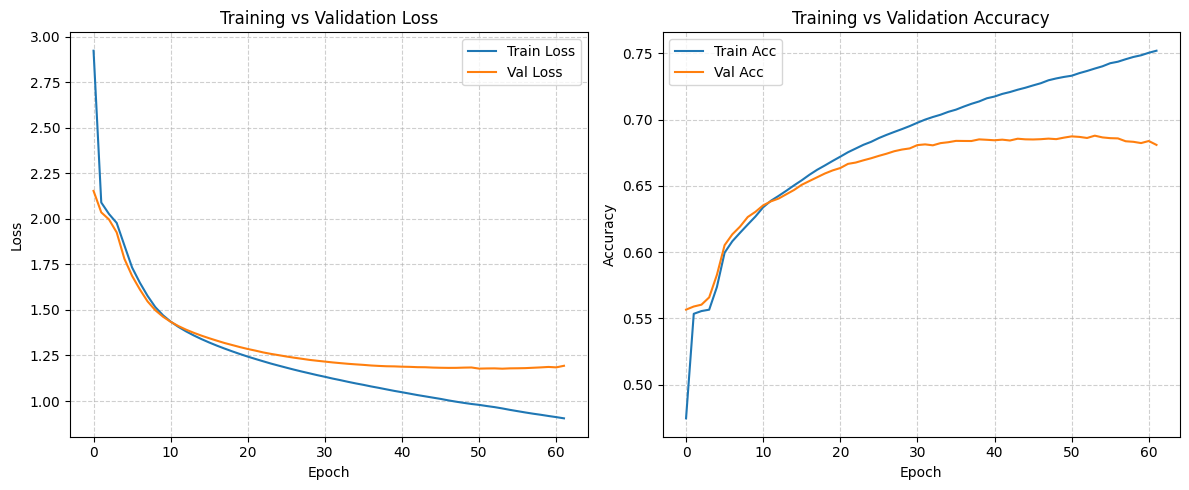

In [50]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    # Accuracy
    if 'accuracy' in history.history:
        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Train Acc')
        plt.plot(history.history['val_accuracy'], label='Val Acc')
        plt.title('Training vs Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.6)
    else:
        plt.subplot(1, 2, 2)
        plt.text(0.5, 0.5, 'No accuracy metric available', ha='center', va='center')
        plt.axis('off')

    plt.tight_layout()
    plt.show()
plot_training_history(history)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Activation, Dot, Concatenate

latent_dim = seq2seq.get_layer("encoder_lstm").units

encoder_inputs = seq2seq.input[0]
encoder_outputs, state_h_enc, state_c_enc = seq2seq.get_layer("encoder_lstm").output
encoder_model = Model(encoder_inputs, [encoder_outputs, state_h_enc, state_c_enc])

dec_state_input_h = Input(shape=(latent_dim,), name="dec_state_h")
dec_state_input_c = Input(shape=(latent_dim,), name="dec_state_c")
enc_outputs_input = Input(shape=(X_tr.shape[1], latent_dim), name="enc_outs_input")
dec_single_input = Input(shape=(1,), name="dec_single_input")

dec_emb_layer = seq2seq.get_layer("dec_embedding")
dec_lstm_layer = seq2seq.get_layer("decoder_lstm")
dense_tanh = seq2seq.layers[-2]   
dense_softmax = seq2seq.layers[-1] 

dec_emb_single = dec_emb_layer(dec_single_input)
dec_out, state_h, state_c = dec_lstm_layer(
    dec_emb_single, initial_state=[dec_state_input_h, dec_state_input_c]
)

attn_scores = Dot(axes=[2,2])([dec_out, enc_outputs_input])
attn_weights = Activation('softmax')(attn_scores)
context = Dot(axes=[2,1])([attn_weights, enc_outputs_input])
concat = Concatenate(axis=-1)([context, dec_out])

proj = dense_tanh(concat)
dec_pred = dense_softmax(proj)

decoder_model = Model(
    [dec_single_input, dec_state_input_h, dec_state_input_c, enc_outputs_input],
    [dec_pred, state_h, state_c]
)

print("encoder_model và decoder_model đã sẵn sàng để inference.")


encoder_model và decoder_model đã sẵn sàng để inference.


In [66]:
import numpy as np
import cv2
from tqdm import tqdm

def decode_sequence_feat(input_feat, encoder_model, decoder_model,
                         mean, std, start_token, end_token, idx_to_char,
                         max_len=100):
    enc_in = (input_feat - mean) / std
    enc_in = np.expand_dims(enc_in, axis=0)
    enc_outs, h, c = encoder_model.predict(enc_in)

    target_token = np.array([[start_token]])
    decoded_chars = []
    for _ in range(max_len):
        preds, h, c = decoder_model.predict([target_token, h, c, enc_outs])
        pred_id = np.argmax(preds[0, 0, :])
        if pred_id in [end_token, 0]:
            break
        ch = idx_to_char.get(pred_id, "")
        decoded_chars.append(ch)
        target_token = np.array([[pred_id]])
    return "".join(decoded_chars)

def predict_sentence(video_path, encoder_model, decoder_model,
                     mean, std, start_token, end_token, idx_to_char,
                     seq_len=30, max_len=100):
    feat = extract_keypoints_from_video(video_path, frame_skip=1)
    if feat.shape[0] == 0:
        return "", 0.0
    arr = pad_or_truncate_feat(feat, seq_len)
    decoded_text = decode_sequence_feat(
        arr, encoder_model, decoder_model, mean, std,
        start_token, end_token, idx_to_char, max_len=max_len
    )
    return decoded_text

test_video = video_entries[3][0]
pred_text = predict_sentence(
    test_video,
    encoder_model, decoder_model,
    mean, std,
    start_token, end_token, idx_to_char,
    seq_len=SEQUENCE_LENGTH
)
print("Video:", test_video)
print("Prediction:", pred_text)
print("Ground truth:", video_entries[3][1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━

In [ ]:
from difflib import SequenceMatcher
import numpy as np
from tqdm import tqdm

def _safe_decode(features_item, encoder_model, decoder_model,
                 mean, std, start_token, end_token, idx_to_char, max_len):
    try:
        resp = decode_sequence_feat(
            features_item, encoder_model, decoder_model,
            mean, std, start_token, end_token, idx_to_char,
            max_len=max_len
        )
    except Exception as e:

        return "", 0.0, f"error: {e}"

    if isinstance(resp, tuple) or isinstance(resp, list):
        if len(resp) == 0:
            return "", 0.0, None
        elif len(resp) == 1:
            return resp[0], 0.0, None
        else:

            return resp[0], float(resp[1]) if resp[1] is not None else 0.0, None
    else:

        return str(resp), 0.0, None


def calculate_seq2seq_accuracy(features, texts, encoder_model, decoder_model,
                               mean, std, start_token, end_token, idx_to_char,
                               seq_len=30, max_len=100, n_samples=None,
                               verbose=True):
    if n_samples is None or n_samples > len(features):
        n_samples = len(features)

    correct_sent = 0
    total_chars_gt = 0.0
    total_chars_match = 0.0
    results = []

    iterator = range(n_samples)
    if verbose:
        iterator = tqdm(iterator, desc="Evaluating accuracy")

    for i in iterator:
        try:
            f_raw = features[i]
            f = pad_or_truncate_feat(f_raw, seq_len)
        except Exception as e:
            results.append({"index": i, "gt": texts[i] if i < len(texts) else None,
                            "pred": "", "conf": 0.0, "char_acc": 0.0, "error": f"feature error: {e}"})
            continue

        pred_text, conf, err = _safe_decode(f, encoder_model, decoder_model,
                                            mean, std, start_token, end_token, idx_to_char, max_len)
        gt = texts[i].strip() if i < len(texts) else ""

        if err is not None:
            results.append({"index": i, "gt": gt, "pred": pred_text, "conf": conf, "char_acc": 0.0, "error": err})
            continue

        if pred_text.strip() == gt:
            correct_sent += 1

        try:
            s = SequenceMatcher(None, pred_text, gt)
            char_acc = s.ratio()
        except Exception:
            char_acc = 0.0

        total_chars_match += char_acc * len(gt)
        total_chars_gt += len(gt)

        results.append({
            "index": i,
            "gt": gt,
            "pred": pred_text,
            "conf": conf,
            "char_acc": round(char_acc, 4),
            "error": None
        })

    sent_acc = (correct_sent / n_samples) if n_samples > 0 else 0.0
    char_acc = (total_chars_match / total_chars_gt) if total_chars_gt > 0 else 0.0

    print(f"Sentence-level accuracy: {sent_acc:.4f}")
    print(f"Character-level accuracy: {char_acc:.4f}")

    return sent_acc, char_acc, results


In [ ]:

model.save(os.path.join(PROCESSED_DIR, "lstm_sentence_model_full.h5"))
import joblib
joblib.dump(le, os.path.join(PROCESSED_DIR, "label_encoder.joblib"))
print("Saved model and label encoder to", PROCESSED_DIR)


# CNN + MEDIAPIPE + TRANS + CTC 


In [1]:
import os
import cv2
import json
import pickle
import numpy as np
from tqdm import tqdm
import mediapipe as mp
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

In [2]:
VIDEO_DIR = "data/videos"
LABEL_JSON = "data/labels.json"
PROCESSED_DIR = "data/processed"
os.makedirs(PROCESSED_DIR, exist_ok=True)

SEQUENCE_LENGTH = 30        
FRAME_SIZE = (224,224)       
FRAME_SKIP = 1              
RND_SEED = 42
np.random.seed(RND_SEED)
tf.random.set_seed(RND_SEED)

USE_CNN_FUSION = True
USE_CTC = True              
CTC_WEIGHT = 0.7           
BATCH_SIZE = 8
EPOCHS = 50
LEARNING_RATE = 1e-4

In [3]:
mp_holistic = mp.solutions.holistic

def mediapipe_detection(image, model):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = model.process(image_rgb)
    return results

def extract_keypoints_from_results(results):
    face = np.zeros(468*3, dtype=np.float32)
    if results.face_landmarks:
        face_landmarks = results.face_landmarks.landmark
        face = np.array([[lm.x, lm.y, lm.z] for lm in face_landmarks], dtype=np.float32).flatten()

    pose = np.zeros(33*4, dtype=np.float32)
    if results.pose_landmarks:
        pose_landmarks = results.pose_landmarks.landmark
        pose = np.array([[lm.x, lm.y, lm.z, getattr(lm, 'visibility', 0.0)] for lm in pose_landmarks], dtype=np.float32).flatten()

    left = np.zeros(21*3, dtype=np.float32)
    if results.left_hand_landmarks:
        lms = results.left_hand_landmarks.landmark
        left = np.array([[lm.x, lm.y, lm.z] for lm in lms], dtype=np.float32).flatten()

    right = np.zeros(21*3, dtype=np.float32)
    if results.right_hand_landmarks:
        lms = results.right_hand_landmarks.landmark
        right = np.array([[lm.x, lm.y, lm.z] for lm in lms], dtype=np.float32).flatten()

    return np.concatenate([face, pose, left, right], axis=0)

In [4]:
resnet = ResNet50(weights='imagenet', include_top=False, pooling='avg', input_shape=(FRAME_SIZE[0], FRAME_SIZE[1], 3))

def extract_cnn_feat_from_frame(frame):
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, FRAME_SIZE)
    x = np.expand_dims(img.astype(np.float32), axis=0)
    x = preprocess_input(x)
    feat = resnet.predict(x, verbose=0)  
    return feat[0].astype(np.float32)

In [5]:
def extract_features_for_video(video_path, frame_skip=FRAME_SKIP, max_frames=None, show_progress=False):
    cap = cv2.VideoCapture(video_path)
    frames_feats = []
    frame_idx = 0
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) if cap.isOpened() else None

    with mp_holistic.Holistic(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        pbar = None
        if show_progress and total_frames:
            pbar = tqdm(total=total_frames, desc=os.path.basename(video_path))
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            if frame_idx % frame_skip == 0:
                results = mediapipe_detection(frame, holistic)
                kp = extract_keypoints_from_results(results)  # (1662,)
                if USE_CNN_FUSION:
                    cnn_feat = extract_cnn_feat_from_frame(frame)  # (2048,)
                    fused = np.concatenate([kp, cnn_feat], axis=0)
                else:
                    fused = kp
                frames_feats.append(fused)
                if max_frames and len(frames_feats) >= max_frames:
                    break
            frame_idx += 1
            if pbar:
                pbar.update(1)
        if pbar:
            pbar.close()
    cap.release()
    if len(frames_feats) == 0:
        dim = 1662 + (2048 if USE_CNN_FUSION else 0)
        return np.zeros((0, dim), dtype=np.float32)
    return np.vstack(frames_feats).astype(np.float32)

In [6]:
assert os.path.exists(LABEL_JSON), f"Không tìm thấy file label.json: {LABEL_JSON}"
with open(LABEL_JSON, "r", encoding="utf-8") as f:
    labels_map = json.load(f)

video_entries = []
for fname, sentence in labels_map.items():
    p = os.path.join(VIDEO_DIR, fname)
    if os.path.exists(p):
        video_entries.append((p, sentence))
    else:
        print("Warning: file not found:", p)

print("Số video sẽ xử lý:", len(video_entries))

features_list = []
texts = []
lengths = []
for video_path, text in tqdm(video_entries, desc="Extract all videos"):
    feats = extract_features_for_video(video_path, frame_skip=FRAME_SKIP, show_progress=False)
    features_list.append(feats)
    texts.append(text)
    lengths.append(feats.shape[0])

with open(os.path.join(PROCESSED_DIR, "features_and_texts_2.pkl"), "wb") as f:
    pickle.dump({"features": features_list, "texts": texts, "lengths": lengths}, f)

print("Đã trích xong. Ví dụ shape sample 0:", features_list[0].shape)


Số video sẽ xử lý: 1881


Extract all videos: 100%|██████████| 1881/1881 [18:11:31<00:00, 34.82s/it]    


Đã trích xong. Ví dụ shape sample 0: (62, 3710)


In [ ]:
def pad_or_truncate_feat(feat, seq_len=SEQUENCE_LENGTH):
    T, D = feat.shape
    if T >= seq_len:
        return feat[:seq_len]
    else:
        pad = np.zeros((seq_len - T, D), dtype=np.float32)
        return np.concatenate([feat, pad], axis=0)

X = np.array([pad_or_truncate_feat(f, SEQUENCE_LENGTH) for f in features_list], dtype=np.float32)
y_texts = np.array(texts)
print("X shape:", X.shape, "y count:", len(y_texts))

In [ ]:
all_text = "\n".join(y_texts)
chars = sorted(list(set(all_text)))
char_to_idx = {c: i+1 for i,c in enumerate(chars)}   
idx_to_char = {i+1: c for i,c in enumerate(chars)}

start_token = len(char_to_idx) + 1
end_token = len(char_to_idx) + 2
pad_token = 0
tgt_vocab_size = len(char_to_idx) + 3  


N = len(y_texts)
lengths_chars = [len(s) for s in y_texts]
cap = int(np.percentile(lengths_chars, 95))
max_target_len = min(max(lengths_chars), max(100, cap))
max_target_len = max(30, max_target_len)

decoder_input = np.zeros((N, max_target_len), dtype=np.int32)
decoder_target = np.zeros((N, max_target_len), dtype=np.int32)
decoder_target_ctc = []  

for i, s in enumerate(y_texts):
    chars_idx = [char_to_idx[c] for c in s if c in char_to_idx]
    if len(chars_idx) > max_target_len - 1:
        chars_idx = chars_idx[:max_target_len-1]
    in_seq = [start_token] + chars_idx
    out_seq = chars_idx + [end_token]
    decoder_input[i, :len(in_seq)] = in_seq
    decoder_target[i, :len(out_seq)] = out_seq
    decoder_target_ctc.append(np.array(chars_idx, dtype=np.int32))

with open(os.path.join(PROCESSED_DIR, "char_maps_2.pkl"), "wb") as f:
    pickle.dump({"char_to_idx": char_to_idx, "idx_to_char": idx_to_char,
                 "start_token": start_token, "end_token": end_token,
                 "max_target_len": max_target_len, "tgt_vocab_size": tgt_vocab_size}, f)

print("Char vocab size:", len(char_to_idx), "max_target_len:", max_target_len)

In [ ]:
from sklearn.model_selection import train_test_split
idxs = np.arange(N)
tr_idx, val_idx = train_test_split(idxs, test_size=0.15, random_state=RND_SEED)

X_tr_raw = X[tr_idx]   
flat_tr = X_tr_raw.reshape(-1, D)
mean = flat_tr.mean(axis=0).astype(np.float32)
std = flat_tr.std(axis=0).astype(np.float32) + 1e-8

def normalize_X(X_in, mean, std):
    return (X_in - mean) / std

X_tr = normalize_X(X_tr_raw, mean, std)
X_val = normalize_X(X[val_idx], mean, std)

with open(os.path.join(PROCESSED_DIR, "feat_norm.pkl"), "wb") as f:
    pickle.dump({"mean": mean, "std": std}, f)
dec_in_tr, dec_in_val = decoder_input[tr_idx], decoder_input[val_idx]
dec_tgt_tr, dec_tgt_val = decoder_target[tr_idx], decoder_target[val_idx]
ctc_tr_labels = [decoder_target_ctc[i] for i in tr_idx]
ctc_val_labels = [decoder_target_ctc[i] for i in val_idx]
def prepare_ctc(labels_list, pad_value=0):
    lengths = np.array([len(l) for l in labels_list], dtype=np.int32)
    if len(lengths)==0:
        return np.zeros((0,1), dtype=np.int32), lengths
    maxl = max(1, int(lengths.max()))
    padded = np.full((len(labels_list), maxl), pad_value, dtype=np.int32)
    for i, l in enumerate(labels_list):
        if len(l)>0:
            padded[i, :len(l)] = l
    return padded, lengths
ctc_tr_padded, ctc_tr_lens = prepare_ctc(ctc_tr_labels)
ctc_val_padded, ctc_val_lens = prepare_ctc(ctc_val_labels)

In [ ]:
def get_positional_encoding(seq_len, d_model):
    pos = np.arange(seq_len)[:,None]; i = np.arange(d_model)[None,:]
    angle = 1/np.power(10000, (2*(i//2))/np.float32(d_model))
    a = pos*angle
    pe = np.zeros((seq_len,d_model)); pe[:,0::2]=np.sin(a[:,0::2]); pe[:,1::2]=np.cos(a[:,1::2])
    return tf.cast(pe, tf.float32)

class EncoderBlock(tf.keras.layers.Layer):
    def __init__(self,d_model,num_heads,dff,drop=0.1):
        super().__init__(); 
        self.mha = tf.keras.layers.MultiHeadAttention(num_heads=num_heads,key_dim=d_model//num_heads)
        self.ffn = tf.keras.Sequential([tf.keras.layers.Dense(dff,activation='relu'), 
                                        tf.keras.layers.Dense(d_model)])
        self.ln1 = tf.keras.layers.LayerNormalization(epsilon=1e-6); 
        self.ln2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.do1 = tf.keras.layers.Dropout(drop); 
        self.do2 = tf.keras.layers.Dropout(drop)
    def call(self,x,training,mask=None):
        a = self.mha(x,x,x,attention_mask=mask); 
        a=self.do1(a,training=training); 
        x1=self.ln1(x+a)
        f = self.ffn(x1); 
        f=self.do2(f,training=training); 
        return self.ln2(x1+f)

class DecoderBlock(tf.keras.layers.Layer):
    def __init__(self,d_model,num_heads,dff,drop=0.1):
        super().__init__(); 
        self.mha1 = tf.keras.layers.MultiHeadAttention(num_heads=num_heads,key_dim=d_model//num_heads)
        self.mha2 = tf.keras.layers.MultiHeadAttention(num_heads=num_heads,key_dim=d_model//num_heads)
        self.ffn = tf.keras.Sequential([tf.keras.layers.Dense(dff,activation='relu'), 
                                        tf.keras.layers.Dense(d_model)])
        self.ln1 = tf.keras.layers.LayerNormalization(epsilon=1e-6); 
        self.ln2 = tf.keras.layers.LayerNormalization(epsilon=1e-6); 
        self.ln3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.do1 = tf.keras.layers.Dropout(drop); 
        self.do2 = tf.keras.layers.Dropout(drop); 
        self.do3 = tf.keras.layers.Dropout(drop)
    def call(self,x,enc_out,training,look_ahead_mask=None,padding_mask=None):
        a1 = self.mha1(x,x,x,attention_mask=look_ahead_mask); 
        a1=self.do1(a1,training=training); x1=self.ln1(x+a1)
        a2 = self.mha2(x1,enc_out,enc_out,attention_mask=padding_mask); 
        a2=self.do2(a2,training=training); 
        x2=self.ln2(x1+a2)
        f = self.ffn(x2); 
        f=self.do3(f,training=training); 
        return self.ln3(x2+f)

In [ ]:
d_model = 512; num_heads = 8; dff = 1024; enc_layers = 3; dec_layers = 3; dropout = 0.1
src_seq_len = SEQUENCE_LENGTH; src_feat_dim = X_tr.shape[2]

encoder_inputs = tf.keras.layers.Input(shape=(src_seq_len, src_feat_dim), name="enc_in")
proj_layer = tf.keras.layers.Dense(d_model, name="proj_dense")
proj = proj_layer(encoder_inputs)
pos_enc_src = get_positional_encoding(src_seq_len, d_model)
x = proj + pos_enc_src[None,:,:]
encoder_blocks = [EncoderBlock(d_model,num_heads,dff,dropout) for _ in range(enc_layers)]
for blk in encoder_blocks: x = blk(x, training=False)
encoder_outputs = x

if USE_CTC:
    ctc_logits_layer = tf.keras.layers.Dense(tgt_vocab_size, name="ctc_logits")
    ctc_logits = ctc_logits_layer(encoder_outputs)
else:
    ctc_logits_layer = tf.keras.layers.Dense(tgt_vocab_size, name="ctc_logits")
    ctc_logits = ctc_logits_layer(encoder_outputs)

decoder_inputs = tf.keras.layers.Input(shape=(max_target_len,), name="dec_in")
dec_emb_layer = tf.keras.layers.Embedding(input_dim=tgt_vocab_size, output_dim=d_model, mask_zero=True, name="dec_emb")
dec_emb = dec_emb_layer(decoder_inputs)
pos_enc_tgt = get_positional_encoding(max_target_len, d_model)
dec_x = dec_emb + pos_enc_tgt[None,:,:]
decoder_blocks = [DecoderBlock(d_model,num_heads,dff,dropout) for _ in range(dec_layers)]
for blk in decoder_blocks: dec_x = blk(dec_x, encoder_outputs, training=False)
decoder_output_layer = tf.keras.layers.Dense(tgt_vocab_size, activation='softmax', name="dec_out")
decoder_logits = decoder_output_layer(dec_x)

full_model = tf.keras.Model([encoder_inputs, decoder_inputs], [decoder_logits, ctc_logits])
full_model.summary()

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss_ce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction='none')

def seq_loss_fn(y_true, y_pred):
    mask = tf.cast(tf.not_equal(y_true,0), tf.float32)
    loss = loss_ce(y_true, y_pred)
    loss *= mask
    return tf.reduce_sum(loss)/(tf.reduce_sum(mask)+1e-8)

def ctc_loss_fn(labels, logits, label_lengths, input_lengths):
    logit_tm = tf.transpose(logits, perm=[1,0,2])
    indices = tf.where(tf.not_equal(labels, 0))
    values = tf.gather_nd(labels, indices)
    sparse = tf.SparseTensor(indices=indices, values=values, dense_shape=tf.cast(tf.shape(labels), tf.int64))
    loss = tf.nn.ctc_loss(labels=sparse, logits=logit_tm, label_length=label_lengths, logit_length=input_lengths, logits_time_major=True, blank_index=0)
    return tf.reduce_mean(loss)

In [ ]:
def make_dataset(X_arr, dec_in_arr, dec_tgt_arr, ctc_labels_padded, ctc_label_lens, batch_size=BATCH_SIZE, shuffle=True):
    input_lengths = np.sum(np.any(np.not_equal(X_arr, 0), axis=2), axis=1).astype(np.int32)
    ds = tf.data.Dataset.from_tensor_slices(({"encoder_inputs":X_arr, "decoder_inputs":dec_in_arr, "input_lengths":input_lengths, "ctc_labels":ctc_labels_padded, "ctc_label_lens":ctc_label_lens}, dec_tgt_arr))
    if shuffle: ds = ds.shuffle(1024, seed=RND_SEED)
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_ds = make_dataset(X_tr, dec_in_tr, dec_tgt_tr, ctc_tr_padded, ctc_tr_lens, BATCH_SIZE, True)
val_ds = make_dataset(X_val, dec_in_val, dec_tgt_val, ctc_val_padded, ctc_val_lens, BATCH_SIZE, False)

In [ ]:
@tf.function
def train_step(batch_inputs, batch_targets):
    enc_in = batch_inputs["encoder_inputs"]; dec_in = batch_inputs["decoder_inputs"]
    input_lengths = tf.cast(batch_inputs["input_lengths"], tf.int32)
    ctc_labels = tf.cast(batch_inputs["ctc_labels"], tf.int32)
    ctc_label_lens = tf.cast(batch_inputs["ctc_label_lens"], tf.int32)
    with tf.GradientTape() as tape:
        seq_preds, ctc_preds = full_model([enc_in, dec_in], training=True)
        loss_seq = seq_loss_fn(batch_targets, seq_preds)
        loss_ctc = ctc_loss_fn(ctc_labels, ctc_preds, ctc_label_lens, input_lengths) if USE_CTC else 0.0
        total = loss_seq + CTC_WEIGHT * loss_ctc
    grads = tape.gradient(total, full_model.trainable_variables)
    optimizer.apply_gradients(zip(grads, full_model.trainable_variables))
    return loss_seq, loss_ctc, total

@tf.function
def val_step(batch_inputs, batch_targets):
    enc_in = batch_inputs["encoder_inputs"]; dec_in = batch_inputs["decoder_inputs"]
    input_lengths = tf.cast(batch_inputs["input_lengths"], tf.int32)
    ctc_labels = tf.cast(batch_inputs["ctc_labels"], tf.int32)
    ctc_label_lens = tf.cast(batch_inputs["ctc_label_lens"], tf.int32)
    seq_preds, ctc_preds = full_model([enc_in, dec_in], training=False)
    loss_seq = seq_loss_fn(batch_targets, seq_preds)
    loss_ctc = ctc_loss_fn(ctc_labels, ctc_preds, ctc_label_lens, input_lengths) if USE_CTC else 0.0
    total = loss_seq + CTC_WEIGHT * loss_ctc
    return loss_seq, loss_ctc, total

best_val = 1e9
for ep in range(1, EPOCHS+1):
    s_seq=s_ctc=s_tot=0.0; steps=0
    for batch_inputs, batch_targets in train_ds:
        a,b,c = train_step(batch_inputs, batch_targets)
        s_seq += a.numpy(); s_ctc += (b.numpy() if USE_CTC else 0.0); s_tot += c.numpy(); steps+=1
    vs_seq=vs_ctc=vs_tot=0.0; vsteps=0
    for batch_inputs, batch_targets in val_ds:
        a,b,c = val_step(batch_inputs, batch_targets)
        vs_seq += a.numpy(); vs_ctc += (b.numpy() if USE_CTC else 0.0); vs_tot += c.numpy(); vsteps+=1
    if vsteps:
        vs_tot /= vsteps
    if vs_tot < best_val:
        best_val = vs_tot
        full_model.save_weights(os.path.join(PROCESSED_DIR, "best_weights.h5"))

In [ ]:
def decode_ids_to_text(id_seq):
    s = []
    for idx in id_seq:
        if idx == 0: continue
        if idx == end_token: break
        if idx == start_token: continue
        c = idx_to_char.get(int(idx), "")
        s.append(c)
    return "".join(s)

def greedy_decode(encoder_input):
    max_out = max_target_len
    dec_in = np.zeros((1, max_out), dtype=np.int32)
    dec_in[0,0] = start_token
    for t in range(1, max_out):
        preds, _ = full_model.predict([encoder_input, dec_in], verbose=0)
        token_probs = preds[0, t-1]  
        next_id = np.argmax(token_probs).astype(np.int32)
        dec_in[0, t] = next_id
        if next_id == end_token:
            break
    return decode_ids_to_text(dec_in[0])

sample_enc = X_val[0:1]
print("Example inference:", greedy_decode(sample_enc))

full_model.save(os.path.join(PROCESSED_DIR, "full_transformer_model_dummy.h5"))
with open(os.path.join(PROCESSED_DIR, "vocab_and_config.pkl"), "wb") as f:
    pickle.dump({"char_to_idx": char_to_idx, "idx_to_char": idx_to_char,
                 "start_token": start_token, "end_token": end_token,
                 "mean": mean, "std": std}, f)

In [ ]:
def safe_decode_ids_to_text(id_seq):
    s=[]
    for idx in id_seq:
        i=int(idx)
        if i==0 or i==start_token: continue
        if i==end_token: break
        c = idx_to_char.get(i, "")
        if c: s.append(c)
    return "".join(s)

def create_look_ahead_mask(size):
    mask = np.triu(np.ones((size,size), dtype=np.float32), k=1)
    return tf.convert_to_tensor((mask==0).astype(np.float32)[None,:,:])

def greedy_decode(encoder_input_raw, mean_array=mean, std_array=std, top_k=8):
    enc = np.asarray(encoder_input_raw)
    if enc.ndim==2: enc = enc[None,:,:]
    enc = (enc - mean_array[None,None,:]) / std_array[None,None,:]
    enc_tf = tf.convert_to_tensor(enc, dtype=tf.float32)
    proj_out = proj_layer(enc_tf)
    proj_out += get_positional_encoding(src_seq_len, d_model)[None,:,:]
    x = proj_out
    for blk in encoder_blocks:
        x = blk(x, training=False, mask=None)
    encoder_out = x
    enc_nonpad = np.any(enc != 0.0, axis=2).astype(np.float32)
    max_out = max_target_len
    dec_ids = [start_token]
    for t in range(1, max_out):
        cur_len = len(dec_ids)
        dec_in_arr = np.array(dec_ids + [0]*(max_out - cur_len), dtype=np.int32)[None,:]
        dec_emb = dec_emb_layer(dec_in_arr)[:, :cur_len, :]
        pos = get_positional_encoding(cur_len, d_model)
        dec_x = dec_emb + pos[None,:,:]
        look_mask = create_look_ahead_mask(cur_len)
        enc_pad = tf.convert_to_tensor(enc_nonpad)[:, None, :]
        for blk in decoder_blocks:
            dec_x = blk(dec_x, encoder_out, training=False, look_ahead_mask=look_mask, padding_mask=enc_pad)
        logits = decoder_output_layer(dec_x)[:, -1, :].numpy()[0]
        if logits.shape[0] != tgt_vocab_size:
            p2 = np.zeros((tgt_vocab_size,), dtype=np.float32); upto=min(logits.shape[0], tgt_vocab_size); p2[:upto]=logits[:upto]; logits=p2
        cand = np.argsort(logits)[::-1][:top_k]
        chosen = None
        for c in cand:
            if c==0: continue
            chosen = int(c); break
        if chosen is None: chosen = int(cand[0])
        dec_ids.append(chosen)
        if chosen==end_token: break
    dec_arr = np.zeros((max_out,), dtype=np.int32); dec_arr[:len(dec_ids)] = dec_ids
    return safe_decode_ids_to_text(dec_arr), dec_arr

sample = X_val[0:1]
decoded, dec_ids = greedy_decode(sample)
print("DECODED:", decoded)

In [ ]:
full_model.save(os.path.join(PROCESSED_DIR, "final_full_model.h5"))
with open(os.path.join(PROCESSED_DIR, "vocab_and_norm.pkl"), "wb") as f:
    pickle.dump({"char_to_idx":char_to_idx,"idx_to_char":idx_to_char,"start_token":start_token,"end_token":end_token,"mean":mean,"std":std}, f)